We use parts of a pretrained VGG model to change a base image into the style of another image. We are implementing this from the paper "A Neural Algorithm of Artistic Style". https://arxiv.org/pdf/1508.06576v2.pdf

In [5]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
vgg = models.vgg16(pretrained=True)
from PIL import Image
import io
import matplotlib.pyplot as plt


#a way to normalize the photo when first brought in
load_and_normalize = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

#The image that we want to change
print('Upload Content Image')
content_image = Image.open('content.png')
content_image = load_and_normalize(np.array(content_image)).unsqueeze(0)
content_image = content_image.cuda()

#The image that needs to change to a certain style
print('\nUpload Style Image')
style_image = Image.open('style.png')
style_image = load_and_normalize(np.array(style_image)).unsqueeze(0)
style_image = style_image.cuda()

Upload Content Image

Upload Style Image


In [2]:
#The network that we're using for the images
class VGGIntermediate(nn.Module):
    def __init__(self, requested=[]):
        super(VGGIntermediate, self).__init__()
        
        #Get the pretrained model and all the layers
        self.intermediates = {}
        self.vgg = models.vgg16(pretrained=True).features.eval()
        
        #We want to get the individual layers
        for i, m in enumerate(self.vgg.children()):
            if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
                m.inplace = False          # the model has a hard time going backwards on the in place functions. 
            
            #Tnis is used to grab a particular layer. We want the layers that get the style, and the content of an image
            if i in requested:
                def curry(i):
                    def hook(module, input, output):
                        self.intermediates[i] = output
                    return hook
                m.register_forward_hook(curry(i))
    
    def forward(self, x):
        self.vgg(x)  
        return self.intermediates

In [3]:
def gram_matrix(image_features):
    a,b, c, d = image_features.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = image_features.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

#The total loss function
class MyLoss(nn.Module):
    def __init__(self, style_layers, content_layer):
        super(MyLoss, self).__init__()
        self.sty_loss = StyleLoss(style_layers)
        self.cont_loss = ContentLoss(content_layer)
        
    def forward(self, gen_im1, gen_im2, gen_im3, gen_im4, gen_im5, gen_im6):
        alpha = .0001
        beta = 10000
        sty_loss_fo = self.sty_loss(gen_im1, gen_im2, gen_im3, gen_im4, gen_im5)
        cont_loss_fo = self.cont_loss(gen_im6)
        total_loss = alpha*cont_loss_fo + beta*sty_loss_fo
        return(total_loss)

#The loss for the style photo
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()    
        #The target_feature[i] are the particular layers of the VGG network we want as outlined in the paper
        self.target_one = gram_matrix(target_feature[0]).detach()
        self.target_two = gram_matrix(target_feature[5]).detach()
        self.target_three = gram_matrix(target_feature[10]).detach()
        self.target_four = gram_matrix(target_feature[17]).detach()
        self.target_five = gram_matrix(target_feature[24]).detach()
        
    def forward(self, gen_im1, gen_im2, gen_im3, gen_im4, gen_im5):
        G1 = gram_matrix(gen_im1)
        G2 = gram_matrix(gen_im2)
        G3 = gram_matrix(gen_im3)
        G4 = gram_matrix(gen_im4)
        G5 = gram_matrix(gen_im5)
        loss_one = F.mse_loss(G1, self.target_one)
        loss_two = F.mse_loss(G2, self.target_two)
        loss_three = F.mse_loss(G3, self.target_three)
        loss_four = F.mse_loss(G4, self.target_four)
        loss_five = F.mse_loss(G5, self.target_five)
        loss = loss_one+loss_two+loss_three+loss_four+loss_five
        return loss
        
#The loss for the content photo    
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target[19].detach()

    def forward(self, gen_im6):
        loss = F.mse_loss(gen_im6, self.target)
        return loss

        


#Get a base image       
generated_image = content_image.clone()

#Instantiate the models with the layers that we want
model_sty = VGGIntermediate([0, 5, 10, 17,24])
model_sty.cuda()
model_cont = VGGIntermediate([19])
model_cont.cuda()
model_gen = VGGIntermediate([0,5,10,17,24,19])
model_gen.cuda()

#Work directly on the image and change them 
style_truth = model_sty(style_image.cuda())
cont_truth = model_cont(content_image.cuda())
model_sty = model_sty.cuda()
model_cont = model_cont.cuda()

#Instantiate the loss, optimizer, and updater
my_objective = MyLoss(style_truth, cont_truth)
optimizer = optim.Adam([generated_image.requires_grad_()], lr=.1)
my_losses = [] 
loop = tqdm(total=2000, position=0)

for epoch in range(2000):
        #Get the gradient and the generated layers for the loss.
        optimizer.zero_grad()
        generated_layers = model_gen(generated_image)
        my_loss = my_objective(generated_layers[0], generated_layers[5], generated_layers[10], 
                               generated_layers[17], generated_layers[24],generated_layers[19])
        my_losses.append(my_loss.item())

        #Update the update bar
        loop.set_description('loss:{:.4f}'.format(my_loss.item()))
        loop.update(1)

        #Update the model
        my_loss.backward(retain_graph=True)
        optimizer.step()
loop.close() 

loss:0.6061: 100%|██████████| 2000/2000 [00:51<00:00, 39.13it/s]  


## Image Results

### Content Image

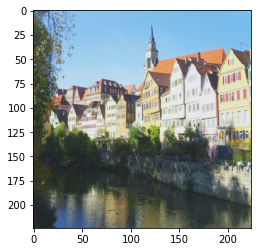

In [11]:
plt.imshow(content_image.view(3,224,224).permute(1,2,0).sigmoid().detach().cpu())

### Style Image

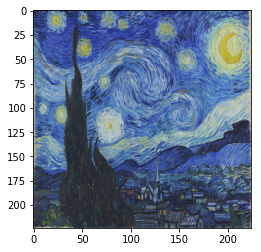

In [12]:
plt.imshow(style_image.view(3,224,224).permute(1,2,0).sigmoid().detach().cpu())

### My Generated Image

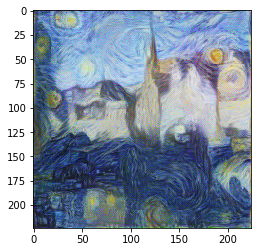

In [13]:
plt.imshow(generated_image.view(3,224,224).permute(1,2,0).sigmoid().detach().cpu())